# Introduction

The objective of our project is to show how user reviews reflect the quality and user experience of Airbnb rentals. In order to achieve this goal, we utilized two text analysis methods, sentiment analysis and TFIDF, to train models that can predict Airbnb ratings based on reviews. Then, we combined the result of these two methods to further improve the accuarcy of the model, and our final model could achieve a prediction accuracy of 67% on our trainning set.

# Research Question

How user reviews of an Airbnb rental reflect its rating?

Does text reflect the actual overall rating of an Airbnb listing?

In [1]:
import sklearn
from sklearn import linear_model
from collections import defaultdict
import numpy as np
import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import pandas as pd

from datetime import datetime
import scipy
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
import string
from scipy.sparse import coo_matrix, hstack, csr_matrix

from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df_info = pd.read_csv("./data/listings_content.csv")
df_info.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20201025051130,2020-10-25,Ocean front condo on the sand,Missionbeachretreat. Great Ocean Front Condo...,While some may compare San Diego’s Mission Bea...,https://a0.muscache.com/pictures/d3342744-140a...,8435,https://www.airbnb.com/users/show/8435,...,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
1,29967,https://www.airbnb.com/rooms/29967,20201025051130,2020-10-25,"Great home, 10 min walk to Beach","This 2 bedroom, 2 full bathroom home offers al...",NaN,https://a0.muscache.com/pictures/76103867/c9b5...,129123,https://www.airbnb.com/users/show/129123,...,10.0,10.0,10.0,NaN,f,5,5,0,0,0.49
2,38245,https://www.airbnb.com/rooms/38245,20201025051130,2020-10-25,Point Loma: Den downstairs,Stay in a 1928 Spanish Style home. Den is dow...,"This neighborhood is an expensive, high-end Po...",https://a0.muscache.com/pictures/f3073822-e493...,164137,https://www.airbnb.com/users/show/164137,...,10.0,9.0,9.0,NaN,f,3,0,3,0,1.16
3,54001,https://www.airbnb.com/rooms/54001,20201025051130,2020-10-25,"La Jolla 2 Bdr Cottage: 1 Qn; 2Twns, Blks 2 Ocn","Quiet, off the beaten path, this secluded cot...","Tranquility, stately trees, meditative, zen-fu...",https://a0.muscache.com/pictures/47035b04-633c...,252692,https://www.airbnb.com/users/show/252692,...,10.0,10.0,10.0,NaN,f,2,1,1,0,1.96
4,62274,https://www.airbnb.com/rooms/62274,20201025051130,2020-10-25,"charming, colorful, close to beach","Modern, cozy, artsy, and european in a lush ga...","We are in walking distance to Starbucks, Trade...",https://a0.muscache.com/pictures/84577734/93ca...,302986,https://www.airbnb.com/users/show/302986,...,10.0,10.0,10.0,NaN,f,2,2,0,0,5.06


In [6]:
df_review_content = pd.read_csv("./data/reviews_content.csv")
df_review_content.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,29967,62788,2010-07-09,151260,Debbie,When I booked our stay in San Diego at Dennis ...
1,29967,64568,2010-07-14,141552,Eric,This was my first experience with using airbnb...
2,29967,67502,2010-07-22,141591,David,We found the house to be very accommodating--e...
3,29967,70466,2010-07-29,125982,Anders,As advertised and more. Dennis was very helpfu...
4,29967,74876,2010-08-07,29835,Miyoko,We had a great time in San Diego. Denis' house...


In [7]:
# rename df_into
df_info = df_info[
    [
        "id",
        "description",
        "neighborhood_overview",
        "host_since",
        "host_response_time",
        "host_response_rate",
        "host_acceptance_rate",
        "host_is_superhost",
        "neighbourhood_cleansed",
        "latitude",
        "longitude",
        "property_type",
        "room_type",
        "accommodates",
        "bedrooms",
        "beds",
        "amenities",
        "price",
        "minimum_nights",
        "availability_365",
        "number_of_reviews",
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
    ]
]

df_info.head()

,id,description,neighborhood_overview,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,latitude,...,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,5570,Missionbeachretreat. Great Ocean Front Condo...,While some may compare San Diego’s Mission Bea...,2009-02-23,NaN,NaN,NaN,f,Mission Bay,32.78430,...,3,197,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29967,"This 2 bedroom, 2 full bathroom home offers al...",NaN,2010-05-21,within an hour,100%,52%,t,Pacific Beach,32.80724,...,4,334,61,98.0,10.0,10.0,10.0,10.0,10.0,10.0
2,38245,Stay in a 1928 Spanish Style home. Den is dow...,"This neighborhood is an expensive, high-end Po...",2010-07-12,within an hour,100%,88%,f,Roseville,32.74202,...,1,320,143,86.0,9.0,9.0,10.0,10.0,9.0,9.0
3,54001,"Quiet, off the beaten path, this secluded cot...","Tranquility, stately trees, meditative, zen-fu...",2010-10-04,within a few hours,95%,72%,t,La Jolla,32.81301,...,3,102,234,99.0,10.0,10.0,10.0,10.0,10.0,10.0
4,62274,"Modern, cozy, artsy, and european in a lush ga...","We are in walking distance to Starbucks, Trade...",2010-11-28,within an hour,100%,95%,t,Pacific Beach,32.80734,...,1,301,609,96.0,10.0,10.0,10.0,10.0,10.0,10.0


In [8]:
df_info.shape

(8688, 28)

In [9]:
# remove the row if there's no reviews to that airbnb
df_info = df_info[(df_info.number_of_reviews > 0)]
# remove the row if there's no review score to that airbnb
df_info = df_info.dropna(subset=["review_scores_value"])
df_info.shape

(7381, 28)

In [10]:
# clean df_info
now = datetime.now()
now = int(now.strftime("%Y%m%d"))

df_info["host_since"] = now - pd.to_numeric(df_info["host_since"].str.replace("-", ""))

df_info["host_response_time"] = df_info["host_response_time"].fillna("NaN")

encoder = LabelEncoder()
df_info["host_response_time"] = encoder.fit_transform(df_info["host_response_time"])

df_info["host_response_rate"] = pd.to_numeric(
    df_info["host_response_rate"].str.replace("%", "")
)

df_info["host_acceptance_rate"] = pd.to_numeric(
    df_info["host_acceptance_rate"].str.replace("%", "")
)

dic = {"t": True, "f": False}
df_info["host_is_superhost"] = df_info["host_is_superhost"].map(dic)

df_info["property_type"] = encoder.fit_transform(df_info["property_type"])

df_info["room_type"] = encoder.fit_transform(df_info["room_type"])

df_info["price"] = df_info["price"].str.replace(",", "")
df_info["price"] = pd.to_numeric(df_info["price"].str.replace("$", ""))

df_info["neighbourhood_lst"] = encoder.fit_transform(df_info["neighbourhood_cleansed"])

df_info.columns = [
    "id",
    "description",
    "neighbor_overview",
    "host_since",
    "response_time",
    "response_rate",
    "acceptance_rate",
    "superhost",
    "neighbourhood",
    "latitude",
    "longitude",
    "property_type",
    "room_type",
    "accommodates",
    "bedrooms",
    "beds",
    "amenities",
    "price",
    "minimum_nights",
    "availability_365",
    "number_of_reviews",
    "rating",
    "accuracy",
    "cleanliness",
    "checkin",
    "communication",
    "location",
    "value",
    "neighbourhood_lst",
]

df_info.head(5)

,id,description,neighbor_overview,host_since,response_time,response_rate,acceptance_rate,superhost,neighbourhood,latitude,...,availability_365,number_of_reviews,rating,accuracy,cleanliness,checkin,communication,location,value,neighbourhood_lst
1,29967,"This 2 bedroom, 2 full bathroom home offers al...",NaN,100695.0,4,100.0,52.0,True,Pacific Beach,32.80724,...,334,61,98.0,10.0,10.0,10.0,10.0,10.0,10.0,69
2,38245,Stay in a 1928 Spanish Style home. Den is dow...,"This neighborhood is an expensive, high-end Po...",100504.0,4,100.0,88.0,False,Roseville,32.74202,...,320,143,86.0,9.0,9.0,10.0,10.0,9.0,9.0,79
3,54001,"Quiet, off the beaten path, this secluded cot...","Tranquility, stately trees, meditative, zen-fu...",100212.0,3,95.0,72.0,True,La Jolla,32.81301,...,102,234,99.0,10.0,10.0,10.0,10.0,10.0,10.0,41
4,62274,"Modern, cozy, artsy, and european in a lush ga...","We are in walking distance to Starbucks, Trade...",100088.0,4,100.0,95.0,True,Pacific Beach,32.80734,...,301,609,96.0,10.0,10.0,10.0,10.0,10.0,10.0,69
5,62949,Wonderful Cozy Private Retreat. Included are u...,"This is the best part of Pacific Beach, we are...",110602.0,4,97.0,98.0,True,Pacific Beach,32.80961,...,66,699,97.0,10.0,10.0,10.0,10.0,10.0,9.0,69


In [11]:
# rename 'id' to 'listing_id'
df_info = df_info.rename(columns={"id": "listing_id"})

# Exploratory and Descriptive Analysis

In [12]:
df_info.describe()

,listing_id,host_since,response_time,response_rate,acceptance_rate,latitude,longitude,property_type,room_type,accommodates,...,availability_365,number_of_reviews,rating,accuracy,cleanliness,checkin,communication,location,value,neighbourhood_lst
count,7.381000e+03,7367.000000,7381.000000,6862.000000,7067.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,...,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000
mean,2.555843e+07,45919.955613,3.404959,95.411979,89.186359,32.768891,-117.188192,13.786750,0.395204,4.813846,...,186.830511,55.771169,94.972361,9.672944,9.566861,9.813304,9.788917,9.811814,9.440049,50.975884
std,1.342662e+07,22530.364099,1.150502,13.787476,20.183483,0.063010,0.064563,10.912341,0.808675,3.122916,...,120.530046,78.684369,7.304770,0.763540,0.769001,0.638928,0.653854,0.583839,0.850532,22.174535
min,2.996700e+04,195.000000,0.000000,0.000000,0.000000,32.531580,-117.281430,0.000000,0.000000,1.000000,...,0.000000,1.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000
25%,1.485837e+07,30698.000000,3.000000,97.000000,90.000000,32.728890,-117.250760,8.000000,0.000000,2.000000,...,79.000000,7.000000,93.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,41.000000
50%,2.551762e+07,41097.000000,4.000000,100.000000,98.000000,32.761320,-117.185660,12.000000,0.000000,4.000000,...,178.000000,24.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,54.000000
75%,3.799765e+07,60707.000000,4.000000,100.000000,100.000000,32.797920,-117.146020,13.000000,0.000000,6.000000,...,304.000000,74.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,66.000000
max,4.587940e+07,110811.000000,4.000000,100.000000,100.000000,33.085820,-116.935710,61.000000,3.000000,16.000000,...,365.000000,743.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,101.000000


In [13]:
# if there's no review content, then we're not able to do text analysis
df_review_content = df_review_content.dropna(subset=['comments'])
df_review_content.shape

(418093, 6)

In [14]:
# we need to do analysis on those listing ids both in df_review_content and in df_info
list_of_id = set(df_info['listing_id']).intersection(set(df_review_content['listing_id']))

# helper function getting df fulfilling the pre-mentioned requirements
def getNewDF(df_ori):
    df_new = pd.DataFrame(df_ori)
    df_new['decide'] = df_new['listing_id'].apply(lambda t: t in list_of_id)
    return df_new[df_new['decide'] == True]

df_review_content = getNewDF(df_review_content)
df_info = getNewDF(df_info)

In [16]:
geo_file = "./data/neighbourhoods.geojson"
sandiego_review = "./data/reviews_content.csv"
df_geo = gpd.read_file(geo_file)
df_review = pd.read_csv(sandiego_review)

In [17]:
df_review = df_review[["listing_id", "comments", "reviewer_id", "date"]]
df_review.columns = ["id", "comments", "reviewer_id", "date"]
df_info["id"] = df_info["listing_id"]

In [18]:
df_info2 = df_info
df_info2 = df_info2.rename({"listing_id": "id"})
df = pd.merge(df_info2, df_review, on="id")

In [19]:
df_info2.head()

,listing_id,description,neighbor_overview,host_since,response_time,response_rate,acceptance_rate,superhost,neighbourhood,latitude,...,rating,accuracy,cleanliness,checkin,communication,location,value,neighbourhood_lst,decide,id
1,29967,"This 2 bedroom, 2 full bathroom home offers al...",NaN,100695.0,4,100.0,52.0,True,Pacific Beach,32.80724,...,98.0,10.0,10.0,10.0,10.0,10.0,10.0,69,True,29967
2,38245,Stay in a 1928 Spanish Style home. Den is dow...,"This neighborhood is an expensive, high-end Po...",100504.0,4,100.0,88.0,False,Roseville,32.74202,...,86.0,9.0,9.0,10.0,10.0,9.0,9.0,79,True,38245
3,54001,"Quiet, off the beaten path, this secluded cot...","Tranquility, stately trees, meditative, zen-fu...",100212.0,3,95.0,72.0,True,La Jolla,32.81301,...,99.0,10.0,10.0,10.0,10.0,10.0,10.0,41,True,54001
4,62274,"Modern, cozy, artsy, and european in a lush ga...","We are in walking distance to Starbucks, Trade...",100088.0,4,100.0,95.0,True,Pacific Beach,32.80734,...,96.0,10.0,10.0,10.0,10.0,10.0,10.0,69,True,62274
5,62949,Wonderful Cozy Private Retreat. Included are u...,"This is the best part of Pacific Beach, we are...",110602.0,4,97.0,98.0,True,Pacific Beach,32.80961,...,97.0,10.0,10.0,10.0,10.0,10.0,9.0,69,True,62949


In [21]:
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
geo_df["price_transform"] = np.log10(geo_df["price"])

(-117.3009741, -116.8901439, 32.50241355, 33.144075449999995)

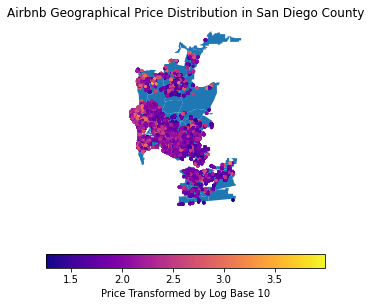

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
divider = make_axes_locatable(ax)
df_geo.plot(ax=ax)
geo_df.plot("price_transform", ax=ax, cmap="plasma", markersize=5, legend=True, legend_kwds={"label": "Price Transformed by Log Base 10","orientation": "horizontal"})
ax.set_title(label="Airbnb Geographical Price Distribution in San Diego County")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.patch.set_visible(False)
ax.axis("off")

In [23]:
month_map = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}


def date_feature(string):
    texts = string.split("-")
    result = texts[0] + "-" + texts[1]
    return result


def date_feature_year(string):
    texts = string.split("-")
    result = texts[0]
    return result


def date_feature_month(string):
    texts = string.split("-")
    #     result = month_map[int(texts[1])]
    result = int(texts[1])
    return result

In [24]:
df["date_transform_year"] = df["date"].apply(lambda x: date_feature_year(x))
df["date_transform_month"] = df["date"].apply(lambda x: date_feature_month(x))

In [25]:
df["date_transform"] = df["date"].apply(lambda x: date_feature(x))
date_count_df = pd.DataFrame()
date_count_df["date_transform"] = df["date_transform"]
date_count_df["rating"] = df["rating"]
date_count_df = date_count_df.groupby("date_transform").count()
date_count_df.head()

,rating
date_transform,
2010-07,4
2010-08,4
2010-09,1
2010-11,2
2010-12,5


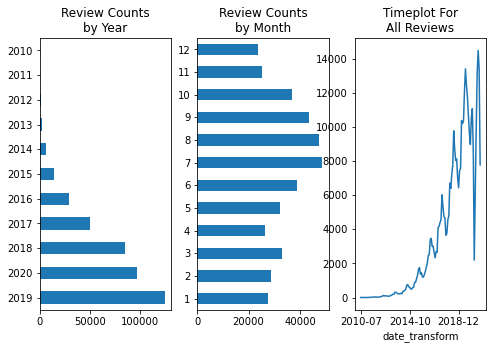

In [47]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 3, 1)
ax.set_title(label="Review Counts\nby Year")
df["date_transform_year"].value_counts().sort_values(ascending=False).plot(kind="barh", ax=ax)
ax = fig.add_subplot(1, 3, 2)
ax.set_title(label="Review Counts\nby Month")
df["date_transform_month"].value_counts().sort_index().plot(kind="barh", ax=ax)
ax = fig.add_subplot(1, 3, 3)
ax.set_title(label="Timeplot For\nAll Reviews")
ax.set_xlabel("date")
date_count_df["rating"].plot(ax=ax)

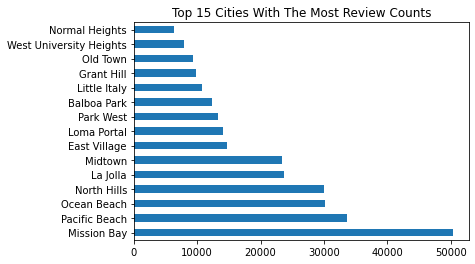

In [48]:
plt.title(label="Top 15 Cities With The Most Review Counts")
geo_df["neighbourhood"].value_counts(ascending=False)[:15].plot.barh()

In [54]:
words_by_year = defaultdict(list)
for index, row in df.iterrows():
    comment_index = list(df.columns).index("comments")
    year_index = list(df.columns).index("date_transform_year")
    words_by_year[int(row[year_index])].append(row[comment_index])
    
keys = list(words_by_year.keys())
keys.sort()


In [52]:
NEW_STOPWORDS = STOPWORDS
NEW_STOPWORDS.add("n")
NEW_STOPWORDS.add("great")
NEW_STOPWORDS.add("place")
NEW_STOPWORDS.add("stay")
NEW_STOPWORDS.add("host")
NEW_STOPWORDS.add("house")

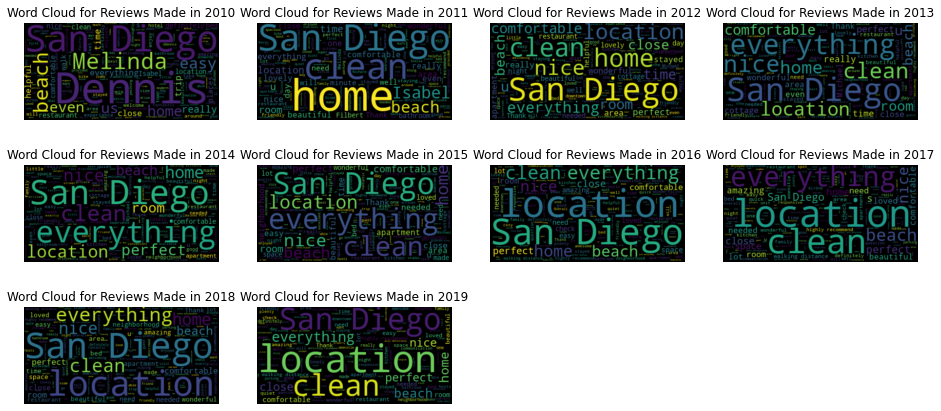

In [59]:
fig = plt.figure(figsize=(16, 10))
for i in range(0, 10):
    year = 2010 + i
    title = "Word Cloud for Reviews Made in " + str(year)
    ax = fig.add_subplot(4, 4, i + 1)
    plt.title(label=title)
    wc = WordCloud(stopwords=NEW_STOPWORDS).generate(str(words_by_year[list(words_by_year.keys())[i]]))
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")

In [61]:
df["rating_transform"] = df["rating"].apply(lambda x: int(int(x)%10))

temp1 = pd.DataFrame()
temp1["neighbourhood"] = df["neighbourhood"]
temp1["rating"] = df["rating"]
temp2 = temp1.groupby("neighbourhood").agg("mean")
final_df = df_geo.merge(
    temp2, how="left", left_on="neighbourhood", right_on="neighbourhood"
)
final_df = final_df.fillna(final_df["rating"].min())
final_df = gpd.GeoDataFrame(final_df)

(-117.30097409999999, -116.89014389999998, 32.5058523, 33.1439117)

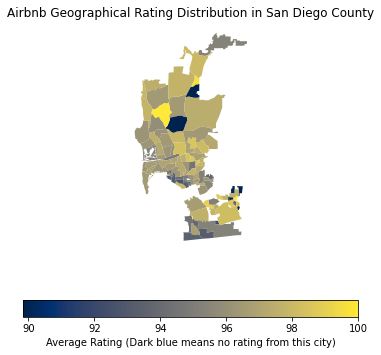

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
final_df.plot("rating", ax=ax, cmap="cividis", markersize=5, legend=True, legend_kwds={"label": "Average Rating (Dark blue means no rating from this city)","orientation": "horizontal"})
ax.set_title(label="Airbnb Geographical Rating Distribution in San Diego County")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.patch.set_visible(False)
ax.axis("off")

In [63]:
temp1 = pd.DataFrame()
temp1["neighbourhood"] = df["neighbourhood"]
temp1["price"] = df["price"]
temp2 = temp1.groupby("neighbourhood").agg("mean")
temp2.head()

final_df = df_geo.merge(
    temp2, how="left", left_on="neighbourhood", right_on="neighbourhood"
)
final_df = final_df.fillna(0)
final_df = gpd.GeoDataFrame(final_df)

(-117.30097409999999, -116.89014389999998, 32.5058523, 33.1439117)

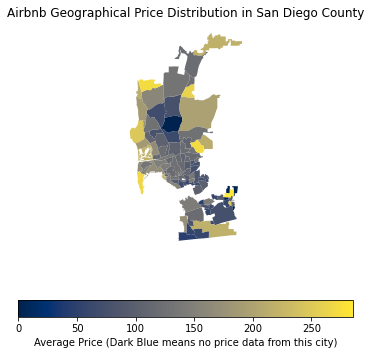

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
final_df.plot("price", ax=ax, cmap="cividis", markersize=5, legend=True, legend_kwds={"label": "Average Price (Dark Blue means no price data from this city)", "orientation": "horizontal",})
ax.set_title(label="Airbnb Geographical Price Distribution in San Diego County")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.patch.set_visible(False)
ax.axis("off")

## Predictions

In [34]:
def differencePredict(actu, pred):
    actu_np = np.array(actu)
    pred_np = np.array(pred)
    diff = actu - pred
    neg = 0 
    for d in diff:
        if d < 0 :
            neg +=1 
    pos = len(diff) - neg
    return neg, pos

In [35]:
# get linear regression mse
def l_r(X, y, test_X, test_y):
    clf = linear_model.LinearRegression()
    clf.fit(X, y)
    pred = clf.predict(test_X)
    return (np.square(np.subtract(pred, test_y)).mean(), *differencePredict(test_y, pred))

In [36]:
# get SVM on variable mse
def svm_con(X, y, test_X, test_y, kernel='rbf'):
    clf = SVC(kernel=kernel, max_iter = 300)
    clf.fit(X, y)
    pred = clf.predict(test_X)
    return (np.square(np.subtract(pred, test_y_sentiment_reg)).mean(), *differencePredict(test_y, pred))

In [37]:
# get logistic regression accuracy
def log_r(X, y, test_X, test_y):
    clf = linear_model.LogisticRegression(max_iter=1000)
    clf.fit(X, y)
    pred = clf.predict(test_X)
    print(classification_report(test_y, pred))
    return (sum(pred == test_y) / len(test_y), *differencePredict(test_y, pred))

In [38]:
# get SVM on variable accuracy
def svm_cla(X, y, test_X, test_y, kernel='rbf'):
    clf = SVC(kernel=kernel, max_iter = 300)
    clf.fit(X, y)
    pred = clf.predict(test_X)
    print(classification_report(test_y, pred))
    return (sum(pred == test_y) / len(test_y), *differencePredict(test_y, pred))

In [39]:
# get performance
def get_performance(train_X, train_y_reg, train_y_cla, test_X, test_y_reg, test_y_cla):
    # linear regression predicting review scores (continuous variable)
    mse_l_r, neg_l_r, pos_l_r = l_r(train_X, train_y_reg, test_X, test_y_reg)
    # svm predicting review scores 
    mse_svm_con, neg_svm_con, pos_svm_con = svm_con(train_X, train_y_reg, test_X, test_y_reg)
    # logistic regression predicting interval of review scores (categorical variable)
    acc_log_r, neg_log_r, pos_log_r = log_r(train_X, train_y_cla, test_X, test_y_cla)
    # svm predicting interval of review scores (categorical variable)
    acc_svm_cla, neg_svm_cla, pos_svm_cla = svm_cla(train_X, train_y_cla, test_X, test_y_cla)
    
    return [mse_l_r, mse_svm_con, acc_log_r, acc_svm_cla, neg_l_r, pos_l_r, neg_svm_con, pos_svm_con, 
            neg_log_r, pos_log_r, neg_svm_cla, pos_svm_cla]

In [40]:
# get training and testing counts
num_listing = df_info.shape[0]
num_training = int(num_listing*0.8)

In [41]:
# build a review_score_dict dictionary
# key: listing_id
# value: review_score
review_score_dict = defaultdict(int)
for i in range(len(df_info)):
    review_score_dict[df_info.iloc[i]['listing_id']] = df_info.iloc[i]['rating']

In [42]:
# build a listing_dict dictionary
# key: listing_id
# value: list of comments
listing_id_list = list(df_review_content["listing_id"])
comments_list = list(df_review_content["comments"])

listing_dict = defaultdict(list)
for i in range(len(listing_id_list)):
    listing_dict[listing_id_list[i]].append(comments_list[i])

##### Sentiment Analysis

In [43]:
# get sentiment score
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon')
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/xus023/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
# build a score dictionary (including neg, neu, pos, compound scores)
# key: listing_id
# value: list of sentiment analysis scores
score_dict = defaultdict(list)
for k in listing_dict.keys():
    li = [analyser.polarity_scores(i) for i in listing_dict[k]]
    score_dict[k] = li

In [45]:
# build a compound_score_dict dictionary (only including compound scores)
# key: listing_id
# value: list of compound  scores
compound_score_dict = defaultdict(list)
for k in score_dict.keys():
    compound_score_dict[k] = [i['compound'] for i in score_dict[k]]

In [46]:
# build a sentiment_score_final_dict dictionary containing average compound scores of each listing_id
# key: listing_id
# value: average compound score
sentiment_score_final_dict = defaultdict(float)
for k in score_dict.keys():
    sentiment_score_final_dict[k] = sum(compound_score_dict[k]) / len(compound_score_dict[k])

In [47]:
# getting training and testing X and y for variable prediction and classification
train_list = list(sentiment_score_final_dict.keys())[:num_training]
test_list = list(sentiment_score_final_dict.keys())[num_training:]

train_X_sentiment = np.array([[sentiment_score_final_dict[k]] for k in train_list])
test_X_sentiment = np.array([[sentiment_score_final_dict[k]] for k in test_list])

train_y_sentiment_reg = np.array([review_score_dict[k] for k in train_list])
test_y_sentiment_reg = np.array([review_score_dict[k] for k in test_list])

train_y_sentiment_cla = np.array([i//10 for i in train_y_sentiment_reg])
test_y_sentiment_cla = np.array([i//10 for i in test_y_sentiment_reg])

In [48]:
(mse_sentiment_l_r, mse_sentiment_svm_con, acc_sentiment_log_r, acc_sentiment_svm_cla, neg_sentiment_l_r, 
pos_sentiment_l_r, neg_sentiment_svm_con, pos_sentiment_svm_con, neg_sentiment_log_r, pos_sentiment_log_r, 
neg_sentiment_svm_cla, pos_sentiment_svm_cla) = get_performance(train_X_sentiment, train_y_sentiment_reg, 
                                                                train_y_sentiment_cla, test_X_sentiment, 
                                                                test_y_sentiment_reg, test_y_sentiment_cla)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.44      0.44      0.44         9
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00        22
         7.0       0.00      0.00      0.00        38
         8.0       0.22      0.08      0.12       199
         9.0       0.44      0.99      0.61       627
        10.0       0.00      0.00      0.00       571

    accuracy                           0.43      1476
   macro avg       0.14      0.19      0.15      1476
weighted avg       0.22      0.43      0.28      1476

              precision    recall  f1-score   support

         2.0       0.45      0.56      0.50         9
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00        22
         7.0       0.00      0.00      0.00        38
         8.0       0.24 

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
mse_sentiment_l_r, mse_sentiment_svm_con

(63.25210661173253, 70.78116531165311)

In [50]:
acc_sentiment_log_r, acc_sentiment_svm_cla

(0.43360433604336046, 0.49525745257452575)

##### tfidf

In [51]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

punctuation = set(string.punctuation)

[nltk_data] Downloading package stopwords to /home/xus023/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
# build a joined_comment_dict dictionary
# key: listing_id
# value: all comments of the corresponding airbnb joined together being one string
Review_byList_df = df_review_content[['listing_id','comments']].groupby(
    'listing_id', as_index = False).agg(lambda x: ' '.join(x.comments.astype(str)))
Review_byList_df = Review_byList_df.drop_duplicates()
listing_id_list = list(Review_byList_df['listing_id'])
comments_list = list(Review_byList_df['comments'])

joined_comment_dict = dict(zip(listing_id_list, comments_list))

In [53]:
# remove stop word, remove punctuation
comments_list = [''.join([c for c in ll if not c in punctuation]) for ll in comments_list]
comments_list = [''.join([c for c in ll if not c in stop_words]) for ll in comments_list]

In [54]:
# see if the order differs
l1 = list(listing_dict.keys())
l2 = list(Review_byList_df['listing_id'])
print("different") if False in [x == l2[i] for i, x in enumerate(l1)] else print("same")

same


In [55]:
tfidf = TfidfVectorizer(sublinear_tf = True, analyzer='word', max_features=2000, tokenizer = word_tokenize)

In [56]:
X = tfidf.fit_transform(comments_list)

In [57]:
X_array = X.toarray()

In [58]:
# getting training and testing X and y for variable prediction and classification
train_X_tfidf = X_array[:num_training]
test_X_tfidf = X_array[num_training:]

train_y_tfidf_reg = train_y_sentiment_reg
test_y_tfidf_reg = test_y_sentiment_reg

train_y_tfidf_cla = train_y_sentiment_cla
test_y_tfidf_cla = test_y_sentiment_cla

In [60]:
(mse_tfidf_l_r, mse_tfidf_svm_con, acc_tfidf_log_r, acc_tfidf_svm_cla, neg_tfidf_l_r, pos_tfidf_l_r, 
 neg_tfidf_svm_con, pos_tfidf_svm_con, neg_tfidf_log_r, pos_tfidf_log_r, neg_tfidf_svm_cla, 
 pos_tfidf_svm_cla) = get_performance(train_X_tfidf, train_y_tfidf_reg, train_y_tfidf_cla, test_X_tfidf, 
                                      test_y_tfidf_reg, test_y_tfidf_cla)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00        22
         7.0       0.00      0.00      0.00        38
         8.0       0.44      0.39      0.41       199
         9.0       0.65      0.80      0.72       627
        10.0       0.76      0.71      0.73       571

    accuracy                           0.66      1476
   macro avg       0.23      0.24      0.23      1476
weighted avg       0.63      0.66      0.64      1476



/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00        22
         7.0       0.00      0.00      0.00        38
         8.0       0.39      0.51      0.44       199
         9.0       0.64      0.59      0.62       627
        10.0       0.64      0.71      0.68       571

    accuracy                           0.60      1476
   macro avg       0.21      0.23      0.22      1476
weighted avg       0.57      0.60      0.58      1476



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
mse_tfidf_l_r, mse_tfidf_svm_con

(81.68163379979633, 120.35704607046071)

In [62]:
acc_tfidf_log_r, acc_tfidf_svm_cla

(0.6646341463414634, 0.5968834688346883)

##### combine sentiment score and tfidf

In [63]:
sentiment_list = [[sentiment_score_final_dict[k]] for k in Review_byList_df['listing_id']]
sentiment_array = csr_matrix(sentiment_list)

In [64]:
# concatinate sentiment score with tfidf
t = coo_matrix(X_array)
s = coo_matrix(sentiment_array)
X_sen_tfidf = hstack([t,s]).toarray()

In [65]:
train_X = X_sen_tfidf[:num_training]
train_y_reg = train_y_tfidf_reg
train_y_cla = train_y_tfidf_cla

test_X = X_sen_tfidf[num_training:]
test_y_reg = test_y_tfidf_reg
test_y_cla = test_y_tfidf_cla

In [66]:
(mse_l_r, mse_svm_con, acc_log_r, acc_svm_cla, neg_l_r, pos_l_r, neg_svm_con, pos_svm_con, neg_log_r, pos_log_r, 
 neg_svm_cla, pos_svm_cla) = get_performance(train_X, train_y_reg, train_y_cla, test_X, test_y_reg, test_y_cla)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         2.0       0.40      0.22      0.29         9
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00        22
         7.0       0.00      0.00      0.00        38
         8.0       0.42      0.38      0.40       199
         9.0       0.68      0.82      0.74       627
        10.0       0.77      0.72      0.74       571

    accuracy                           0.68      1476
   macro avg       0.28      0.27      0.27      1476
weighted avg       0.64      0.68      0.66      1476



/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

         2.0       0.55      0.67      0.60         9
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00        22
         7.0       0.00      0.00      0.00        38
         8.0       0.38      0.46      0.42       199
         9.0       0.63      0.59      0.61       627
        10.0       0.64      0.71      0.67       571

    accuracy                           0.59      1476
   macro avg       0.27      0.30      0.29      1476
weighted avg       0.57      0.59      0.58      1476



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
mse_l_r, mse_svm_con

(59.53680345012333, 72.95663956639567)

In [68]:
acc_log_r, acc_svm_cla

(0.676829268292683, 0.5914634146341463)

# Metrics

In [69]:
mse_sentiment_l_r, mse_sentiment_svm_con, mse_tfidf_l_r, mse_tfidf_svm_con, mse_l_r, mse_svm_con

(63.25210661173253,
 70.78116531165311,
 81.68163379979633,
 120.35704607046071,
 59.53680345012333,
 72.95663956639567)

In [70]:
acc_sentiment_log_r, acc_sentiment_svm_cla, acc_tfidf_log_r, acc_tfidf_svm_cla, acc_log_r, acc_svm_cla

(0.43360433604336046,
 0.49525745257452575,
 0.6646341463414634,
 0.5968834688346883,
 0.676829268292683,
 0.5914634146341463)

Smallest MSE occurs when using both tfidf and sentiment score as X, using linear regression as the model, to predict exact review scores.

Greatest accuracy occurs when using both tfidf and sentiment score as X, using logistic regression as the model, to classify the review scores.

For linear regression predicting exact score:
 	sentiment score: predict lower than actual: 629, predict higher than actual: 847
 	tfidf score: predict lower than actual: 635, predict higher than actual: 841
	both: predict lower than actual: 679, predict higher than actual: 797
For svm predicting exact score:
 	sentiment score: predict lower than actual: 557, predict higher than actual: 919
 	tfidf score: predict lower than actual: 734, predict higher than actual: 742
	both: predict lower than actual: 713, predict higher than actual: 763
For logistic regression interval:
 	sentiment score: predict lower than actual: 253, predict higher than actual: 1223
 	tfidf score: predict lower than actual: 299, predict higher than actual: 1177
	both: predict lower than actual: 288, predict higher than actual: 1188
For svm predicting interval:
 	sentiment score: predict lower than actual: 521, predict higher than actual: 955
 	tfidf score: predict lower than actual: 361, predict higher than actual:

# Conclusion & Discussion

After trying out different types of text analysis and regressions, the best we can get is a prediction model with an accuracy rate of 67%. This accuracy rate is not very high but it is coherent with our hypothesis: we can find some correlations between reviews and ratings, but customers are less likely to leave direct harsh comments in their reviews, or in another word, under a text environment. Therefore, we can conclude that user reviews don't fully reflect the actual ratings of Airbnb rentals. To find a high-quality place, customers should not blindly trust user reviews, instead, they should also take other features into their consideration. Furthermore, we found that by combining TFIDF with sentiment scores, we could improve the prediction accuracy of our model. It makes sense since the property of TFIDF allows us to select words that are particularly important for certain documents. It could make the analysis more representative and targeted.